<a href="https://colab.research.google.com/github/sapto-nugroho/PCD/blob/main/PCD_Assignment03/PCD_Assignment03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Nama : Sapto Nugroho

##NIU : 565712

Implement one of the segmentation methods and several operation of morphological methods without using library. Comparing the segmentation result with and without applying morphological processing.

Create your notebook with name as "PCD_Assignment03". You need to provide your Google Colab's code link to the text editor in submission form.

### Import

In [1]:
!ls
!git clone https://github.com/sapto-nugroho/PCD.git
!ls

sample_data
Cloning into 'PCD'...
remote: Enumerating objects: 693, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 693 (delta 74), reused 19 (delta 19), pack-reused 558 (from 1)
Receiving objects: 100% (693/693), 32.41 MiB | 12.26 MiB/s, done.
Resolving deltas: 100% (215/215), done.
PCD  sample_data


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, io, img_as_float
import cv2
import copy

### Input

In [3]:
def show_img(input):
  plt.figure(figsize=(10,3))
  plt.imshow(input, cmap='gray')
  plt.title(f"Original {input.shape[0]} x {input.shape[1]}")
  plt.axis("off")
  plt.show()

def show_hist(input):
  img1d = input.ravel()
  sorted = np.sort(img1d)
  bins = np.arange(0, 257)
  fig = plt.figure(figsize =(10, 7))
  plt.hist(sorted, bins)
  plt.title("Histogram")
  plt.show()


In [4]:
def input_img(img_path):
  img0 = cv2.imread(img_path)
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img0 = cv2.cvtColor(img0, cv2.COLOR_RGB2GRAY)
  # img = img_as_float(img)
  img = copy.deepcopy(img0)
  # print(img.shape)
  # print(img)

  return img

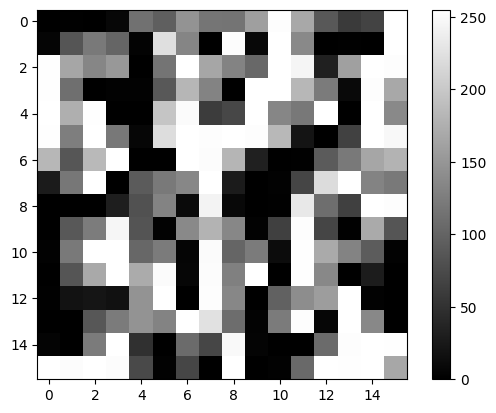

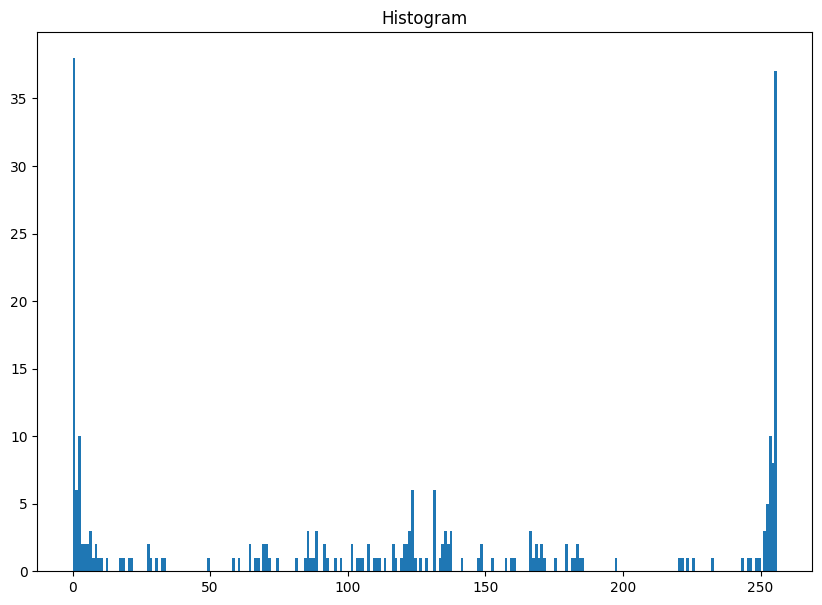

In [19]:
img_path = {
    "woman": '/content/PCD/PCD_Assignment03/images/woman01.jpg',
    "doc": '/content/PCD/PCD_Assignment03/images/script.png',
    "grid": '/content/PCD/PCD_Assignment03/images/grid.jpg',
    "16": '/content/PCD/PCD_Assignment03/images/16x16.jpg',
    "8": '/content/PCD/PCD_Assignment03/images/8x8.jpg',
    "4": '/content/PCD/PCD_Assignment03/images/4x4.jpg'
}

# img_path.extend(['/content/PCD/PCD_Assignment03/images/woman01.jpg','/content/PCD/PCD_Assignment03/images/script.png','/content/PCD/PCD_Assignment03/images/grid.jpg',
#                  '/content/PCD/PCD_Assignment03/images/16x16.jpg','/content/PCD/PCD_Assignment03/images/8x8.jpg','/content/PCD/PCD_Assignment03/images/4x4.jpg'])
# print(img_path)

img = input_img(img_path["16"])
show_img(img)
show_hist(img)

### **Segmentasi**

####  **Pixel based**



##### Basic Global Thresholding

Threshold (T):  159.0


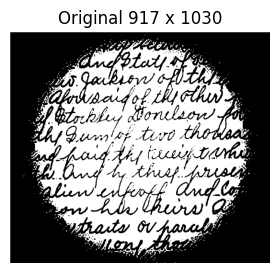

In [6]:
def global_threshold(input):
  input = input.astype(np.float64)
  output = np.zeros_like(input)
  img1d = input.ravel()
  sorted = np.sort(img1d)
  val, freq = np.unique(img1d, return_counts=True)

  T1 =np.floor(np.mean(img1d))#Nilai Threshold
  T2 = T1
  T3 = 0
  sorted = np.sort(img1d)

  while (T3-T1 != 0):
    first = sorted[sorted <= T2]
    second = sorted[sorted > T2]
    T1 = T2
    # print(first)
    # print(second)
    # print(np.floor(np.mean(first)))
    # print(np.floor(np.mean(second)))

    m1 = np.floor(np.mean(first))
    m2 = np.floor(np.mean(second))
    T3 = (m1+m2)/2
    # print(T1)
    # print(T3)
    # print(T3-T1)
    T2 = T3

  T3 = np.floor(T3)
  print("Threshold (T): ",T3)

  for i in range(input.shape[0]):
    for j in range(input.shape[1]):
      if input[i,j] > T3:
        output[i,j] = 255
      else:
        output[i,j] = 0

  return output

output = global_threshold(img)
show_img(output)

##### Otsu Method

Threshold (T):  162.0


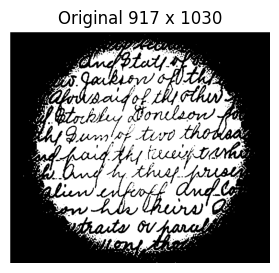

In [7]:
def otsu(input):
  input = input.astype(np.float64)
  img1d = input.ravel()
  output = np.zeros_like(input)
  sorted = np.sort(img1d)
  val, freq = np.unique(sorted, return_counts=True)
  # print(val)
  # print(freq)

  # val_freq = np.stack((val,freq), axis=1)
  # print(val_freq)

  var_w = np.zeros(len(val))

  for i in range(1,len(val)):

    weight_b = np.sum(freq[0:i])/np.sum(freq)
    mean_b = np.sum(val[0:i]*freq[0:i])/np.sum(freq[0:i])
    var_b = np.sum(((val[0:i]-mean_b)**2)*freq[0:i])/np.sum(freq[0:i])

    weight_f = np.sum(freq[i:])/np.sum(freq)
    mean_f = np.sum(val[i:]*freq[i:])/np.sum(freq[i:])
    var_f = np.sum(((val[i:]-mean_f)**2)*freq[i:])/np.sum(freq[i:])

    var_w[i] = weight_b*var_b + weight_f*var_f

  # print(var_w.shape)
  # print(var_w)

  mask = (var_w != 0) & ~np.isnan(var_w)
  min_idx = np.nanargmin(np.where(mask, var_w, np.nan))
  min_val = var_w[min_idx]
  # print(min_idx, min_val)
  T = val[min_idx]
  print("Threshold (T): ",T)

  for i in range(input.shape[0]):
    for j in range(input.shape[1]):
      if input[i,j] > T:
        output[i,j] = 255
      else:
        output[i,j] = 0

  return output

output = otsu(img)
show_img(output)

##### Adaptive Thresholding

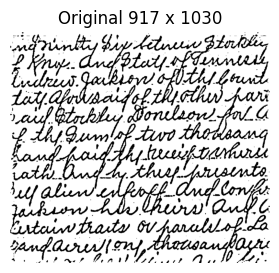

In [8]:
def moving_avg(input,n,c):

  output = np.zeros_like(input)
  input = input.astype(np.float64)
  kernel = np.ones((n, n), dtype=np.float64) / (n * n)
  ksize = kernel.shape[0]
  pad = ksize // 2
  # h, w = input.shape
  # kh, kw = kernel.shape
  # pad_h, pad_w = kh // 2, kw // 2

  # Padding citra
  padded = np.pad(input, pad, mode='constant')
  # padded = np.pad(input, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')

  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      region = padded[i:i+ksize, j:j+ksize]
      T = np.sum(region * kernel)*c
      if input[i,j] > T:
        output[i,j] = 255
      else:
        output[i,j] = 0

  return output

out = moving_avg(img,31,0.95)
show_img(out)

###### Split image

Total blocks: 16


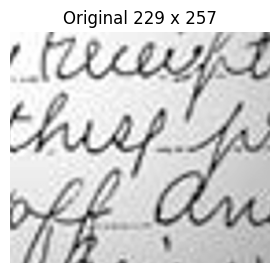

In [9]:
def split_img_blocks(img, rows, cols):
    """Split image into (rows × cols) sub-blocks without cropping."""
    h, w = img.shape[:2]

    # Compute split indices (evenly spaced)
    row_splits = np.linspace(0, h, rows + 1, dtype=int)
    col_splits = np.linspace(0, w, cols + 1, dtype=int)

    # Slice using NumPy indexing
    blocks = [
        img[row_splits[i]:row_splits[i+1], col_splits[j]:col_splits[j+1]]
        for i in range(rows)
        for j in range(cols)
    ]
    return blocks

rows, cols = 4, 4
block = split_img_blocks(img, rows, cols)

print("Total blocks:", len(block))
# print(block[0])
# print("Each block shape:")
# for i, b in enumerate(block):
#     print(f" Block {i}: {b.shape}")

show_img(block[10])

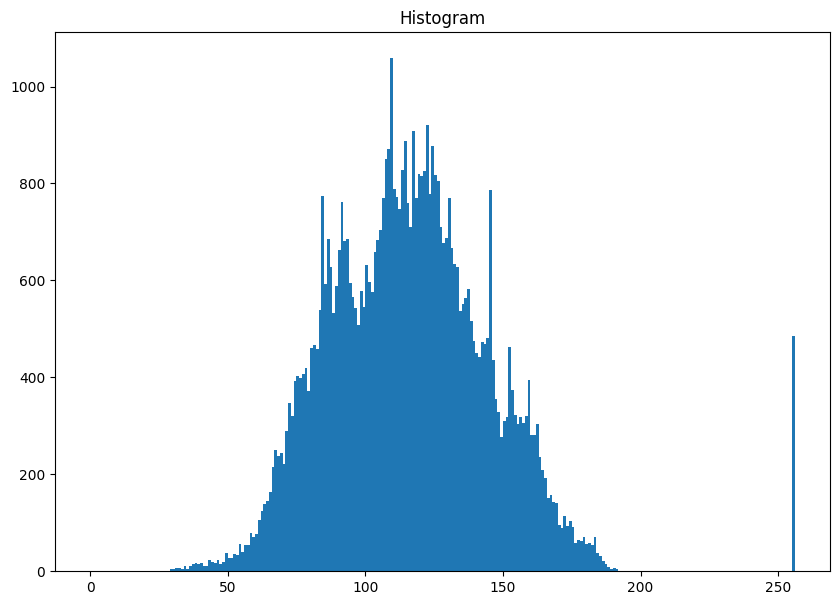

In [10]:
block1d = []
val = []
freq = []
for i in range(len(block)):
  block1d.append(block[i].ravel())

for i in range(len(block1d)):
  nilai, frekuensi = np.unique(block1d[i], return_counts=True)
  val.append(nilai)
  freq.append(frekuensi)

# print(val[0])

show_hist(block1d[0])

Threshold (T):  182.0


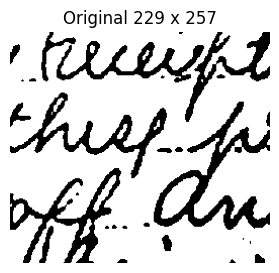

In [11]:
output1 = otsu(block[10])
show_img(output1)

##### Probability Thresholding
Algoritma

*   Data = citra-citra objek yang ingin dideteksi, contoh: asap, api, air, dll
*   Training data, hitung nilai mean dan variance lalu buat distribusinya
*   Distribusi sebagai nilai acuan untuk piksel pada citra baru
*   Gunakan fungsi Gaussian untuk menentukan piksel termasuk objek atau bukan





In [ ]:
# def prob_threshold():
#   Algorithm Thresholding_By_Probability

#   Input:
#       Image RGB berukuran M × N
#       μR, μG, μB     ← rata-rata kanal warna dari data pelatihan
#       σR, σG, σB     ← standar deviasi kanal warna dari data pelatihan
#       T              ← nilai ambang probabilitas

#   Output:
#       BinaryMask[M][N]

#   Begin
#       For i ← 1 to M do
#           For j ← 1 to N do
#               (R, G, B) ← nilai piksel pada (i, j)

#               // Hitung probabilitas Gaussian untuk tiap kanal
#               PR ← (1 / (√(2π) * σR)) * exp( -((R - μR)^2) / (2 * σR^2) )
#               PG ← (1 / (√(2π) * σG)) * exp( -((G - μG)^2) / (2 * σG^2) )
#               PB ← (1 / (√(2π) * σB)) * exp( -((B - μB)^2) / (2 * σB^2) )

#               // Asumsikan ketiga kanal independen
#               Ptotal ← PR * PG * PB

#               // Bandingkan dengan nilai ambang probabilitas
#               If Ptotal > T then
#                   BinaryMask[i][j] ← 1   // piksel termasuk objek
#               Else
#                   BinaryMask[i][j] ← 0   // piksel bukan objek
#               EndIf
#           EndFor
#       EndFor

#       Return BinaryMask
#   End

#   return output

####  **Region based**

##### Region Growing

In [ ]:
print(neighbors[0]+seed)
print(range(seed.shape[0]))

[[2 4]]
range(0, 1)


In [ ]:
# imag = np.array([[0,0,0,0,0,0,0,0],
#                  [0,0,0,5,5,0,0,0],
#                  [0,0,5,5,5,5,0,0],
#                  [0,0,5,5,5,5,5,0],
#                  [0,5,5,5,5,5,0,0],
#                  [0,0,5,5,5,5,0,0],
#                  [0,0,0,5,5,0,0,0],
#                  [0,0,0,0,0,0,0,0]])

imag = np.array([[0,0,0,0,0,0,0,0],
                 [0,0,0,5,3,0,0,0],
                 [0,0,5,1,5,5,0,0],
                 [0,0,4,5,4,1,3,0],
                 [0,5,5,4,5,5,0,0],
                 [0,0,5,3,5,4,0,0],
                 [0,0,0,2,2,0,0,0],
                 [0,0,0,0,0,0,0,0]])
show_img(imag)

#MASK
mask = np.zeros_like(imag)

#SEED
# seed = [np.random.randint(imag.shape[0]),np.random.randint(imag.shape[1])]
# seed = np.array([[3,3],[4,4],[5,5]])
seed = np.array([[3,3]])
# print(seed)
# seed = np.vstack([seed,[1,5]])
# print(seed)

#8-NEIGHBORS
neighbors = np.array([[0,1],[0,-1],[1,0],[-1,0],
                      [1,1],[1,-1],[-1,1],[-1,-1]])
# print(neighbors)

#Masukkan koordinat dalam mask
for x in seed:
  # print(x)
  # print(x[1])
  # print(mask[x[0],x[1]])
  mask[x[0],x[1]] = 1

print(mask)
# show_img(mask)

#Cek neighbors memenuhi threshold?
T = 1
for x in seed:
  print('x : ', x,'====================================')
  for y in neighbors:
    z = x+y
    # print(z)
    # print(z[1])

    #Masukkan koordinat neighbors yang memenuhi dalam array seed
    if imag[z[0],z[1]] >= imag[x[0],x[1]] - T and imag[z[0],z[1]] <= imag[x[0],x[1]] + T:

      if mask[z[0],z[1]] == 0:
        mask[z[0],z[1]] = 1
      # if not np.any(seed == z):
        seed = np.vstack([seed,[z[0],z[1]]])

      print(seed)
  # print(seed[0])

 #Delete koordinat acuan yang sudah digunakan dari array seed
  seed = seed[1:]
  print(seed)

print(mask)
show_img(mask)

for i in range(imag.shape[0]):
  for j in range(imag.shape[1]):
    if imag[i,j] >= T:
      mask[i,j] = 0
    else:
      mask[i,j] = 1
# show_img(mask)


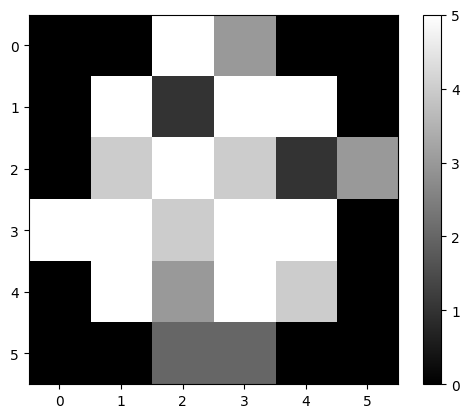

seed digunakan: [3 3]
neighbors dari [3 3] ===============
2 2
2 3
2 4
3 2
3 4
4 2
4 3
4 4
list seed===========================
[[2 2]
 [2 3]
 [3 2]
 [3 4]
 [4 3]
 [4 4]]
seed digunakan: [2 2]
neighbors dari [2 2] ===============
1 1
1 2
1 3
2 1
2 3
3 1
3 2
3 3
list seed===========================
[[2 3]
 [3 2]
 [3 4]
 [4 3]
 [4 4]
 [1 1]
 [1 3]
 [2 1]
 [3 1]]
seed digunakan: [2 3]
neighbors dari [2 3] ===============
1 2
1 3
1 4
2 2
2 4
3 2
3 3
3 4
list seed===========================
[[3 2]
 [3 4]
 [4 3]
 [4 4]
 [1 1]
 [1 3]
 [2 1]
 [3 1]
 [1 4]]
seed digunakan: [3 2]
neighbors dari [3 2] ===============
2 1
2 2
2 3
3 1
3 3
4 1
4 2
4 3
list seed===========================
[[3 4]
 [4 3]
 [4 4]
 [1 1]
 [1 3]
 [2 1]
 [3 1]
 [1 4]
 [4 1]
 [4 2]]
seed digunakan: [3 4]
neighbors dari [3 4] ===============
2 3
2 4
2 5
3 3
3 5
4 3
4 4
4 5
list seed===========================
[[4 3]
 [4 4]
 [1 1]
 [1 3]
 [2 1]
 [3 1]
 [1 4]
 [4 1]
 [4 2]]
seed digunakan: [4 3]
neighbors dari [4 3] ===========

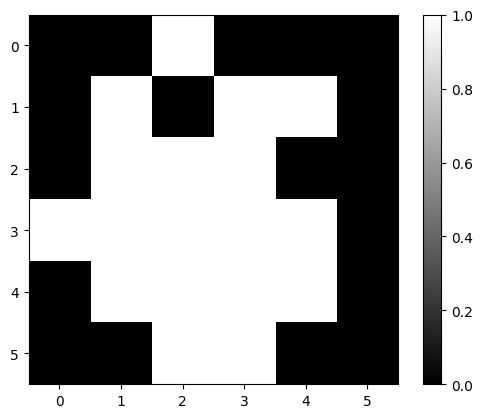

In [66]:
import numpy as np
import matplotlib.pyplot as plt

def show_img(img):
    plt.imshow(img, cmap='gray')
    plt.colorbar()
    plt.show()

# Citra contoh
# imag = np.array([[0,0,0,0,0,0,0,0],
#                  [0,0,0,5,3,0,0,0],
#                  [0,0,5,1,5,5,0,0],
#                  [0,0,4,5,4,1,3,0],
#                  [0,5,5,4,5,5,0,0],
#                  [0,0,5,3,5,4,0,0],
#                  [0,0,0,2,2,0,0,0],
#                  [0,0,0,0,0,0,0,0]])

imag = np.array([[0,0,5,3,0,0],
                 [0,5,1,5,5,0],
                 [0,4,5,4,1,3],
                 [5,5,4,5,5,0],
                 [0,5,3,5,4,0],
                 [0,0,2,2,0,0]])

# show_img(imag)

def reg_grow(input):
  # MASK kosong
  mask = np.zeros_like(input)

  # SEED awal
  seed = np.array([[3, 3]])   # (row, col)
  T = 1                       # threshold perbedaan intensitas

  # 8-NEIGHBORS
  neighbors = np.array([[-1,-1],[-1,0],[-1,1],
                        [0,-1],        [0,1],
                        [1,-1],[1,0],[1,1]])

  # Tandai seed awal di mask
  mask[seed[0,0], seed[0,1]] = 1

  # Mulai region growing
  while len(seed) > 0:

    # print('==================================')
    # print(seed)
    print('====================================')
    x = seed[0]     # ambil seed pertama
    print('seed digunakan:', x)
    # print('==================================')
    seed = seed[1:] # hapus seed pertama
    print('neighbors dari',x,'===============')
    for y in neighbors:
        z = x + y    # koordinat tetangga
        k, b = z
        print(k,b)

        # Cek batas citra
        if k < 0 or k >= input.shape[0] or b < 0 or b >= input.shape[1]:
            continue

        # Cek kondisi threshold
        if abs(input[k, b] - input[x[0], x[1]]) <= T and mask[k, b] == 0:
            mask[k, b] = 1
            seed = np.vstack([seed, [k, b]])

    print('list seed===========================')
    print(seed)
    # print('==================================')
  return mask

show_img(imag)
out = reg_grow(imag)
show_img(out)


##### Watershed / Flood fill

##### Clustering

#### **Feature based / Detection**

##### Sliding Window

### **Morphological Process**